(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import Antibiotic
import Antibiotic.mh as mh

# Import ML libraries
import CUDA
import cuDNN
import AutoEncoderToolkit as AET
import Flux

# Import libraries to handle data
import Glob
import DimensionalData as DD
import DataFrames as DF
import JLD2

# Import basic math libraries
import StatsBase
import LinearAlgebra
import Random
import Distributions
import Distances

# Load CairoMakie for plotting
import Makie
using CairoMakie
import PairPlots
import ColorSchemes

# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.theme_makie!()

# From Latent to Phenotypic Coordinates

In this notebook, we will explore the problem of mapping the learned latent
space representation into the original phenotypic space. Our Metropolis-Hastings
evolutionary dynamics assign coordinates in phenotypic space for particular
random walkers that represent an evolving population. These walkers undergo
adaptive dynamics on a specific fitness landscape and a genetic density
landscape, trying to increase their overall fitness. Then, we sample multiple
fitness landscapes, computing the corresponding fitness for each phenotypic
coordinate the walkers visited. Finally, given only these fitness values, we
train an `RHVAE` model to map the high-dimensional fitness profile into a
low-dimensional latent space.

We can think of this process as a form of _non-linear triangulation_, where
we use the fitness information to backtrack the relative positions of each
walker in the phenotypic space. This is a form of _inverse_ problem, where we
are trying to infer the _causes_ (i.e. the phenotypic coordinates) of the
observed _effects_ (i.e. the fitness values).

An immediate consequence of this interpretation of the learned latent space is
that there must exist a _bijective_ mapping between the phenotypic space and the
latent space. This is a very strong requirement, and it is something that we
should be able to test empirically. What this means is that there must exist a
function $\underline{g}$ such that $\underline{g}(\underline{z}) =
\underline{x}$, where $\underline{z} \in \mathbb{R}^d$ is a point in the latent
space and $\underline{x} \in \mathbb{R}^n$ is a point in the phenotypic space.
Of course, this function is not known, but we can try to infer it from the data
using a simple neural network architecture. This is the object of this notebook.

## Loading simulated dynamics

Let's begin by loading the simulated dynamics in phenotypic space.

In [9]:
# Locate current directory
path_dir = "$(git_root())/code/processing/metropolis-hastings_sim/v02"

# Find the path perfix where input data is stored
out_prefix = replace(
    match(r"processing/(.*)", path_dir).match,
    "processing" => "",
)

# Define simulation directory
sim_dir = "$(git_root())/output$(out_prefix)/sim_evo"
# Define model directory
vae_dir = "$(git_root())/output$(out_prefix)/vae"
# Define output directory
state_dir = "$(vae_dir)/model_state"

# Define the subsampling interval
n_sub = 10

# Load fitnotype profiles
fitnotype_profiles = JLD2.load("$(sim_dir)/sim_evo.jld2")["fitnotype_profiles"]

# Extract initial and final time points
t_init, t_final = collect(DD.dims(fitnotype_profiles, :time)[[1, end]])
# Subsample time series
fitnotype_profiles = fitnotype_profiles[time=DD.At(t_init:n_sub:t_final)]

# Define number of environments
n_env = length(DD.dims(fitnotype_profiles, :landscape))

# Extract fitness data bringing the fitness dimension to the first dimension
fit_data = permutedims(fitnotype_profiles.fitness, (5, 1, 2, 3, 4, 6))
# Reshape the array to a Matrix
fit_data = reshape(fit_data.data, size(fit_data.data, 1), :)

# Log-transform fitness data
fit_mat = log.(fit_data)

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment 
dt = StatsBase.fit(StatsBase.ZScoreTransform, fit_mat, dims=2)

# Standardize the data to have mean 0 and standard deviation 1
log_fitnotype_std = DD.mapslices(
    slice -> StatsBase.transform(dt, slice),
    log.(fitnotype_profiles.fitness),
    dims=:landscape,
)

╭────────────────────────────────────╮
│ 1×31×5×3×50×50 DimArray{Float32,6} │
├────────────────────────────────────┴─────────────────────────────────── dims ┐
  ↓ fitness   Categorical{Symbol} [:fitness] ForwardOrdered,
  → time      Sampled{Int64} [0, 10, …, 290, 300] ForwardOrdered Irregular Points,
  ↗ lineage   Sampled{Int64} 1:5 ForwardOrdered Regular Points,
  ⬔ replicate Sampled{Int64} 1:3 ForwardOrdered Regular Points,
  ◩ landscape,
  ⬒ evo       Sampled{Int64} 1:50 ForwardOrdered Regular Points
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1, 1, 1]
 ↓ →         0         10         …  280       290        300
  :fitness  -0.518942  -0.710203       1.7584    1.64268    1.55957

Now, let's plot the phenotype data. 

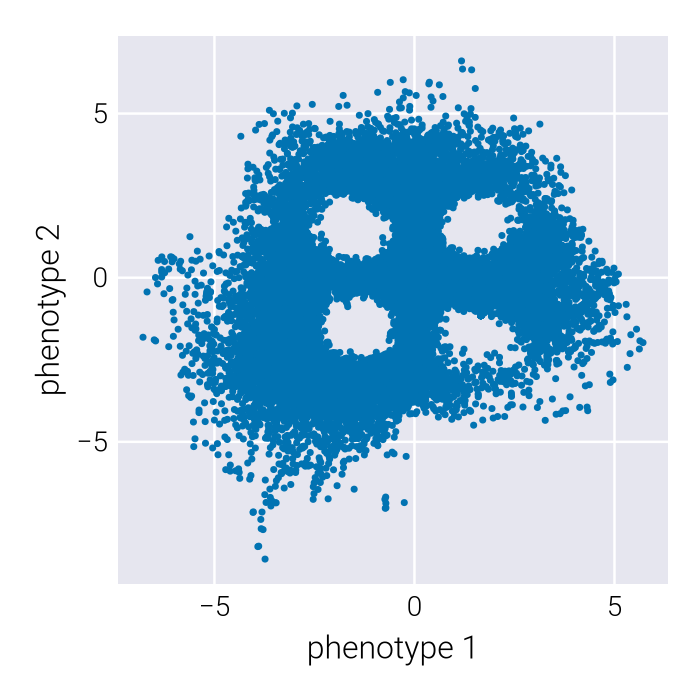

In [10]:
# Initialize figure
fig = Figure(size=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    aspect=AxisAspect(1),
    xlabel="phenotype 1",
    ylabel="phenotype 2",
)

# Plot scatter
mapslices(
    slice -> scatter!(
        ax,
        Point2f.(eachcol(slice)),
        markersize=5,
        color=ColorSchemes.seaborn_colorblind[1],
    ),
    fitnotype_profiles.phenotype[landscape=DD.At(1)].data,
    dims=[1],
)

fig

## Loading `RHVAE` model

With the data in hand, we can now load the `RHVAE` model that we trained on
the fitness profiles.

In [11]:
# Define loss function hyper-parameters
ϵ = Float32(1E-3) # Leapfrog step size
K = 10 # Number of leapfrog steps
βₒ = 0.3f0 # Initial temperature for tempering

# Define RHVAE hyper-parameters in a dictionary
rhvae_kwargs = (K=K, ϵ=ϵ, βₒ=βₒ,)

# Find model file
model_file = first(Glob.glob("$(vae_dir)/model*.jld2"[2:end], "/"))
# List epoch parameters
model_states = sort(Glob.glob("$(state_dir)/*.jld2"[2:end], "/"))
# Load model
rhvae = JLD2.load(model_file)["model"]
# Load latest model state
Flux.loadmodel!(rhvae, JLD2.load(model_states[end])["model_state"])
# Update metric parameters
AET.RHVAEs.update_metric!(rhvae)

typeof(rhvae)

AutoEncoderToolkit.RHVAEs.RHVAE{AutoEncoderToolkit.VAEs.VAE{JointGaussianLogEncoder{…}, SimpleGaussianDecoder{…}}}

Next, let's map the fitness profiles into the `RHVAE` latent space.

In [19]:
# Define latent space dimensions
latent = DD.Dim{:latent}([:latent1, :latent2])

# Map data to latent space
dd_latent = DD.DimArray(
    dropdims(
        mapslices(slice -> rhvae.vae.encoder(slice).μ,
            log_fitnotype_std.data,
            dims=[5]);
        dims=1
    ),
    (log_fitnotype_std.dims[2:4]..., latent, log_fitnotype_std.dims[6]),
)

# Permute dimensions to have latent coordinates in the first dimension
dd_latent = DD.permutedims(dd_latent, (4, 1, 2, 3, 5))

╭─────────────────────────────────╮
│ 2×31×5×3×50 DimArray{Float32,5} │
├─────────────────────────────────┴────────────────────────────────────── dims ┐
  ↓ latent    Categorical{Symbol} [:latent1, :latent2] ForwardOrdered,
  → time      Sampled{Int64} [0, 10, …, 290, 300] ForwardOrdered Irregular Points,
  ↗ lineage   Sampled{Int64} 1:5 ForwardOrdered Regular Points,
  ⬔ replicate Sampled{Int64} 1:3 ForwardOrdered Regular Points,
  ◩ evo       Sampled{Int64} 1:50 ForwardOrdered Regular Points
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1, 1]
 ↓ →         0         10          …  280         290        300
  :latent1  -1.66184   -1.64127         2.25444     1.91217    1.85796
  :latent2  -0.191453  -0.0112969      -0.771362   -0.72963   -0.504566

Let's plot the latent space coordinates.

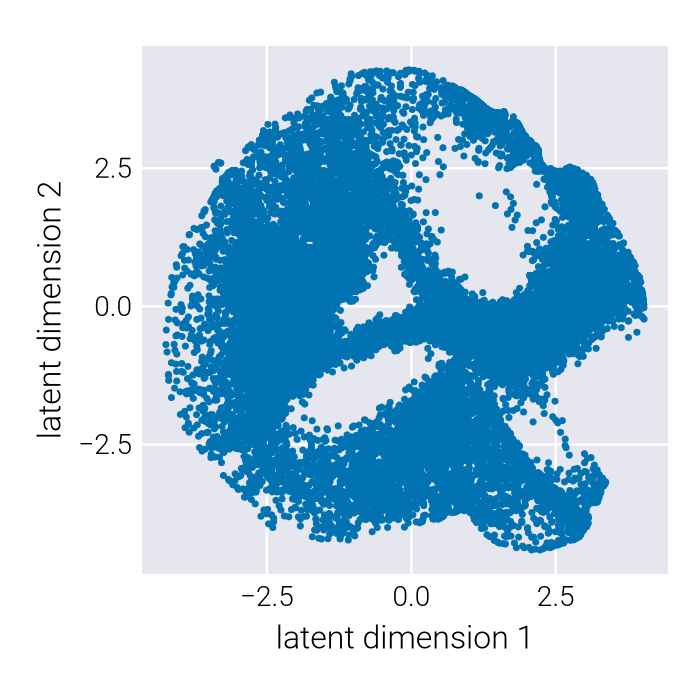

In [20]:
# Initialize figure
fig = Figure(size=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    aspect=AxisAspect(1),
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
)

# Plot scatter
DD.mapslices(
    slice -> scatter!(
        ax,
        Point2f.(eachcol(slice)),
        markersize=5,
        color=ColorSchemes.seaborn_colorblind[1],
    ),
    dd_latent,
    dims=:latent,
)

fig

To make the comparison between the phenotype and latent space coordinates even
more obvious, let's plot both coordinates next to each other.

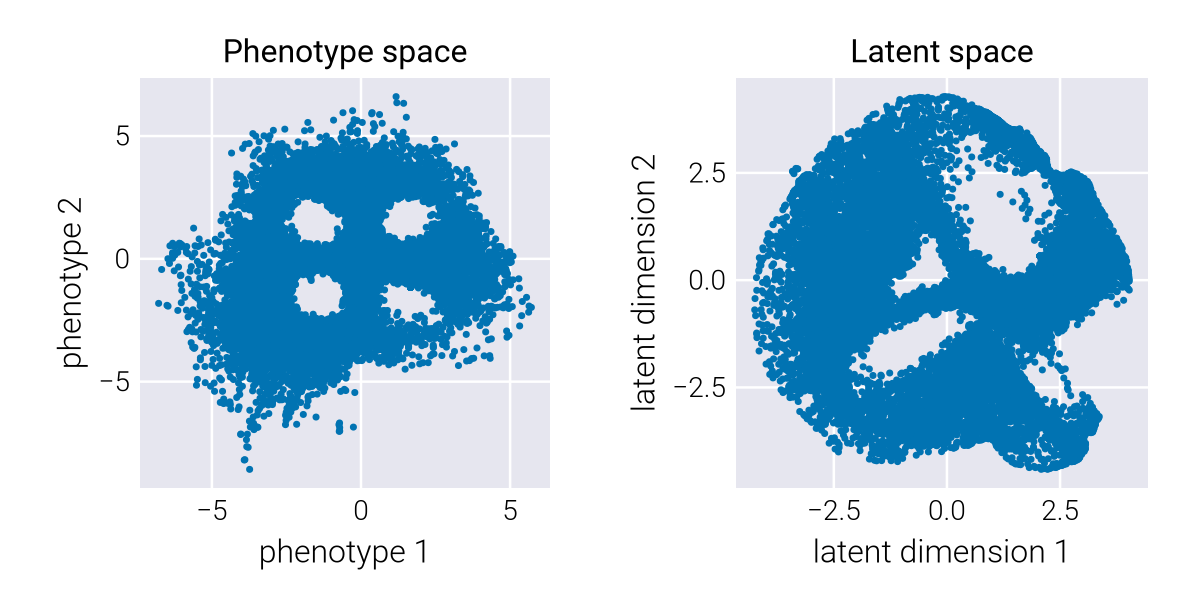

In [21]:
# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for phenotype coordinates
ax_pheno = Axis(
    fig[1, 1],
    aspect=AxisAspect(1),
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    title="Phenotype space",
)

# Add axis for latent coordinates
ax_latent = Axis(
    fig[1, 2],
    aspect=AxisAspect(1),
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    title="Latent space",
)

# Plot scatter for phenotype coordinates
DD.mapslices(
    slice -> scatter!(
        ax_pheno,
        Point2f.(eachcol(slice)),
        markersize=5,
        color=ColorSchemes.seaborn_colorblind[1],
    ),
    fitnotype_profiles.phenotype[landscape=DD.At(1)],
    dims=:phenotype,
)

# Plot scatter for latent coordinates
DD.mapslices(
    slice -> scatter!(
        ax_latent,
        Point2f.(eachcol(slice)),
        markersize=5,
        color=ColorSchemes.seaborn_colorblind[1],
    ),
    dd_latent,
    dims=:latent,
)

fig

From this projection, we can see a qualitative agreement between the
phenotype and latent space coordinates. 

## Non-linear triangulation

Given the qualitative agreement between the phenotype and latent space
coordinates, we can now try to infer the mapping function $\underline{g}$
from the latent space to the phenotype space. To do this, we will train a
simple feedforward neural network to learn the mapping function.

Let's define the neural network architecture using `Flux.jl`.

In [22]:
Random.seed!(42)

# Define neural network architecture
nn = Flux.Chain(
    Flux.Dense(2 => 64, Flux.identity),
    Flux.Dense(64 => 64, Flux.leakyrelu),
    Flux.Dense(64 => 64, Flux.leakyrelu),
    Flux.Dense(64 => 64, Flux.leakyrelu),
    Flux.Dense(64 => 64, Flux.leakyrelu),
    Flux.Dense(64 => 2, Flux.identity),
)

# Move model to GPU
nn = Flux.gpu(nn)

Chain(
  Dense(2 => 64),                       # 192 parameters
  Dense(64 => 64, leakyrelu),           # 4_160 parameters
  Dense(64 => 64, leakyrelu),           # 4_160 parameters
  Dense(64 => 64, leakyrelu),           # 4_160 parameters
  Dense(64 => 64, leakyrelu),           # 4_160 parameters
  Dense(64 => 2),                       # 130 parameters
)                   # Total: 12 arrays, 16_962 parameters, 1.867 KiB.

Next, let's format the input and output data for the neural network.

In [30]:
Random.seed!(42)

# Define fraction of data to use for training
split_frac = 0.85

# Format input data
z_in = reduce(hcat, eachslice(dd_latent.data, dims=(2, 3, 4, 5), drop=true))
# Format output data
x_out = reduce(
    hcat,
    eachslice(
        fitnotype_profiles.phenotype[landscape=DD.At(1)].data,
        dims=(2, 3, 4, 5),
        drop=true
    )
)

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment 
dz = StatsBase.fit(StatsBase.ZScoreTransform, z_in, dims=2)
# Standardize the data to have mean zero and standard deviation 1
z_in_std = StatsBase.transform(dz, z_in)

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment 
dx = StatsBase.fit(StatsBase.ZScoreTransform, x_out, dims=2)
# Standardize the data to have mean zero and standard deviation 1
x_out_std = StatsBase.transform(dx, x_out)

# Split indexes of data into training and validation
train_idx, val_idx = Flux.splitobs(
    1:size(z_in, 2), at=split_frac, shuffle=true
)

# Split input and output data into training and validation
z_in_train, z_in_val = [
    z_in_std[:, train_idx] |> Flux.gpu, z_in_std[:, val_idx] |> Flux.gpu
]
x_out_train, x_out_val = [
    x_out_std[:, train_idx] |> Flux.gpu, x_out_std[:, val_idx] |> Flux.gpu
]

# Check that input and output data have the same size
println("Input and output data have the same size: $(size(z_in_train) == size(x_out_train))")

Input and output data have the same size: true


We are now ready to train the neural network. We will use the mean squared error
as the loss function.

In [31]:
Random.seed!(42)

# Define learning rate
η = 1E-3
# Define number of epochs
n_epochs = 1_000

# Explicit setup of optimizer
opt_nn = Flux.Train.setup(
    Flux.Optimisers.Adam(η),
    nn
)
# Initialize loss array
loss_train = []
loss_val = []
# Initialize array to store model state
model_state = Dict()

# Loop through number of epochs
for epoch in 1:n_epochs
    # Compute loss and gradients
    loss, grads = Flux.withgradient(nn) do nn
        # Forward pass on input data
        x̂ = nn(z_in_train)
        # Compute loss
        Flux.Losses.mse(x̂, x_out_train)
    end
    # Update model parameters
    Flux.update!(opt_nn, nn, grads[1])
    # Store loss
    push!(loss_train, loss)
    # Compute validation loss
    x̂_val = nn(z_in_val)
    push!(loss_val, Flux.Losses.mse(x̂_val, x_out_val))
    # Print progress
    if epoch % 250 == 0
        println("Epoch $(epoch) of $(n_epochs)")
        println("Training loss: $(loss_train[end])")
        println("Validation loss: $(loss_val[end])")
        model_state[epoch] = Flux.state(nn)
    end
end


Epoch 250 of 1000
Training loss: 0.022681015
Validation loss: 0.019270819
Epoch 500 of 1000
Training loss: 0.016254082
Validation loss: 0.017089969
Epoch 750 of 1000
Training loss: 0.011677342
Validation loss: 0.016370188
Epoch 1000 of 1000
Training loss: 0.00998392
Validation loss: 0.014798896


Let's plot the training and validation loss.

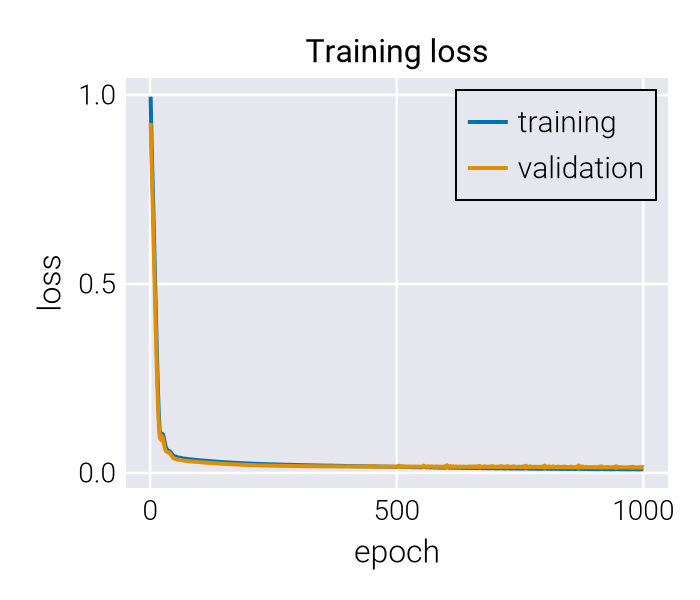

In [33]:
# Initialize figure
fig = Figure(size=(350, 300))

# Add axis for training loss
ax_train = Axis(
    fig[1, 1],
    title="Training loss",
    xlabel="epoch",
    ylabel="loss",
    # yscale=log10,
)

# Plot training loss
lines!(
    ax_train,
    loss_train,
    color=ColorSchemes.seaborn_colorblind[1],
    label="training",
)

# Add validation loss
lines!(
    ax_train,
    loss_val,
    color=ColorSchemes.seaborn_colorblind[2],
    label="validation",
)

# Add legend
axislegend(ax_train)

fig

From this plot, we can see that there is no clear overfitting, so let's use the
model state at the last epoch.

In [34]:
# Load model state
Flux.loadmodel!(nn, model_state[1000])
# Move model to CPU
nn = Flux.cpu(nn)

Chain(
  Dense(2 => 64),                       # 192 parameters
  Dense(64 => 64, leakyrelu),           # 4_160 parameters
  Dense(64 => 64, leakyrelu),           # 4_160 parameters
  Dense(64 => 64, leakyrelu),           # 4_160 parameters
  Dense(64 => 64, leakyrelu),           # 4_160 parameters
  Dense(64 => 2),                       # 130 parameters
)                   # Total: 12 arrays, 16_962 parameters, 66.867 KiB.

Next, let's map the latent space coordinates to the phenotype space using the
trained neural network.

In [47]:
# Map latent space coordinates to phenotype space.
# NOTE: This includes standardizing the input data to have mean zero and
# standard deviation one and then transforming the output data back to the
# original scale.
dd_nn = DD.DimArray(
    DD.mapslices(
        slice -> StatsBase.reconstruct(
            dx,
            nn(StatsBase.transform(dz, Vector(slice))),
        ),
        dd_latent,
        dims=:latent,
    ),
    (
        DD.dims(fitnotype_profiles.phenotype)[1],
        dd_latent.dims[2:end]...,
    ),
)

╭─────────────────────────────────╮
│ 2×31×5×3×50 DimArray{Float32,5} │
├─────────────────────────────────┴────────────────────────────────────── dims ┐
  ↓ phenotype Categorical{Symbol} [:x1, :x2] ForwardOrdered,
  → time      Sampled{Int64} [0, 10, …, 290, 300] ForwardOrdered Irregular Points,
  ↗ lineage   Sampled{Int64} 1:5 ForwardOrdered Regular Points,
  ⬔ replicate Sampled{Int64} 1:3 ForwardOrdered Regular Points,
  ◩ evo       Sampled{Int64} 1:50 ForwardOrdered Regular Points
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1, 1]
 ↓ →    0        10        20        …  280         290         300
  :x1  -2.60186  -2.64169  -2.81637       0.511628    0.285443    0.332573
  :x2  -1.43145  -1.95375  -1.74068       0.577232    0.464378    0.117254

Let's plot the real and predicted phenotype coordinates next to each other.

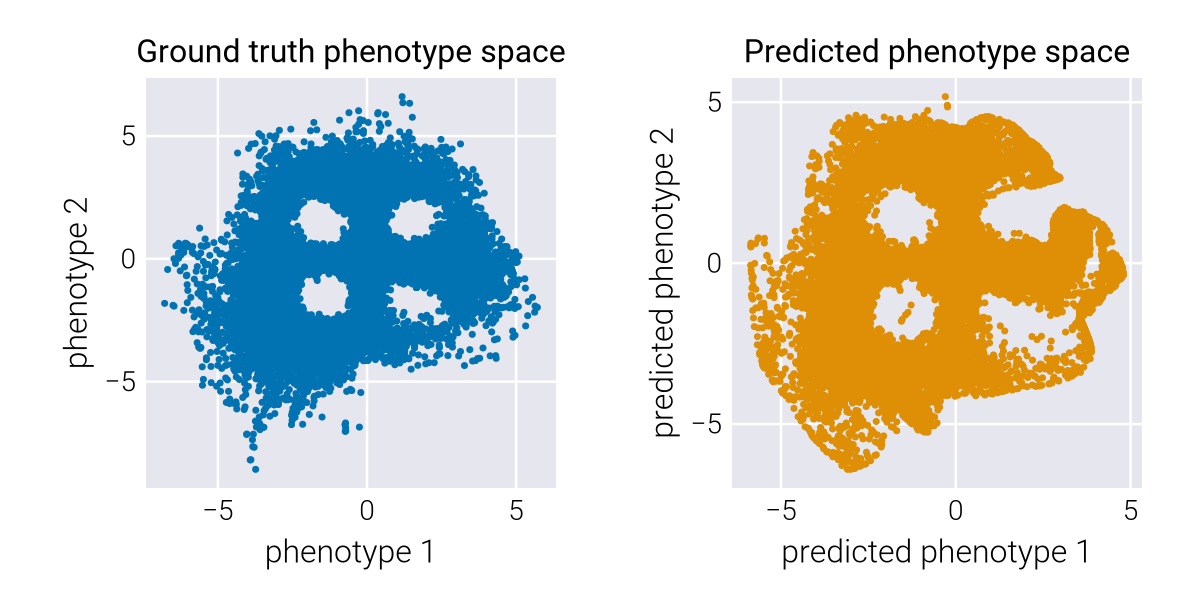

In [49]:
# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for phenotype coordinates
ax_pheno = Axis(
    fig[1, 1],
    aspect=AxisAspect(1),
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    title="Ground truth phenotype space",
)

# Add axis for predicted phenotype coordinates
ax_pred = Axis(
    fig[1, 2],
    aspect=AxisAspect(1),
    xlabel="predicted phenotype 1",
    ylabel="predicted phenotype 2",
    title="Predicted phenotype space",
)

# Plot scatter for phenotype coordinates
DD.mapslices(
    slice -> scatter!(
        ax_pheno,
        Point2f.(eachcol(slice)),
        markersize=5,
        color=ColorSchemes.seaborn_colorblind[1],
    ),
    fitnotype_profiles.phenotype[landscape=DD.At(1)],
    dims=:phenotype,
)

# Plot scatter for predicted phenotype coordinates
DD.mapslices(
    slice -> scatter!(
        ax_pred,
        Point2f.(eachcol(slice)),
        markersize=5,
        color=ColorSchemes.seaborn_colorblind[2],
    ),
    dd_nn,
    dims=:phenotype,
)

fig